In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from check_and_prepare_dataset import load_dataset

In [71]:
def plot_spearman(dfcorr, tsize=(16,12)):
    plt.figure(figsize = tsize)
    corr = dfcorr.corr(method = 'spearman')
    sns.heatmap(corr, annot = True, annot_kws={"size": 35 / np.sqrt(len(corrmat))},)
    plt.show()

In [49]:
X_pd, y_pd, groups_pd = load_dataset('/mnt/nvme2tb/ffp/datasets/fires_new_norm.csv',['bin'])

Loading full dataset /mnt/nvme2tb/ffp/datasets/fires_new_norm.csv
before nan drop: 26604
after nan drop: 26604
after dup. drop: 26517
renaming "x": "xpos", "y": "ypos"
Ignored columns from csv ['Unnamed: 0', 'dom_dir', 'dir_max', 'fire', 'weekday', 'month', 'x', 'y', 'firedate', 'band']
Dropped columns ['bin_weekday_2', 'bin_corine_gr22', 'bin_corine_gr23', 'bin_dom_dir_7', 'bin_dom_dir_5', 'bin_dir_max_6', 'bin_month_6', 'bin_dir_max_1', 'bin_dom_dir_8', 'bin_dir_max_7', 'bin_month_9', 'bin_dir_max_3', 'bin_month_5', 'bin_dom_dir_1', 'bin_dom_dir_6', 'bin_corine_gr4', 'bin_dir_max_4', 'bin_month_10', 'bin_weekday_7', 'bin_weekday_1', 'bin_weekday_6', 'bin_weekday_3', 'bin_month_8', 'bin_weekday_4', 'bin_corine_gr24', 'bin_dom_dir_4', 'bin_dom_dir_2', 'bin_month_3', 'bin_dom_dir_3', 'bin_month_7', 'bin_dir_max_5', 'bin_dir_max_8', 'bin_corine_gr5', 'bin_corine_gr21', 'bin_corine_gr32', 'bin_corine_gr1', 'bin_month_4', 'bin_corine_gr31', 'bin_weekday_5', 'bin_dir_max_2', 'bin_corine_gr3

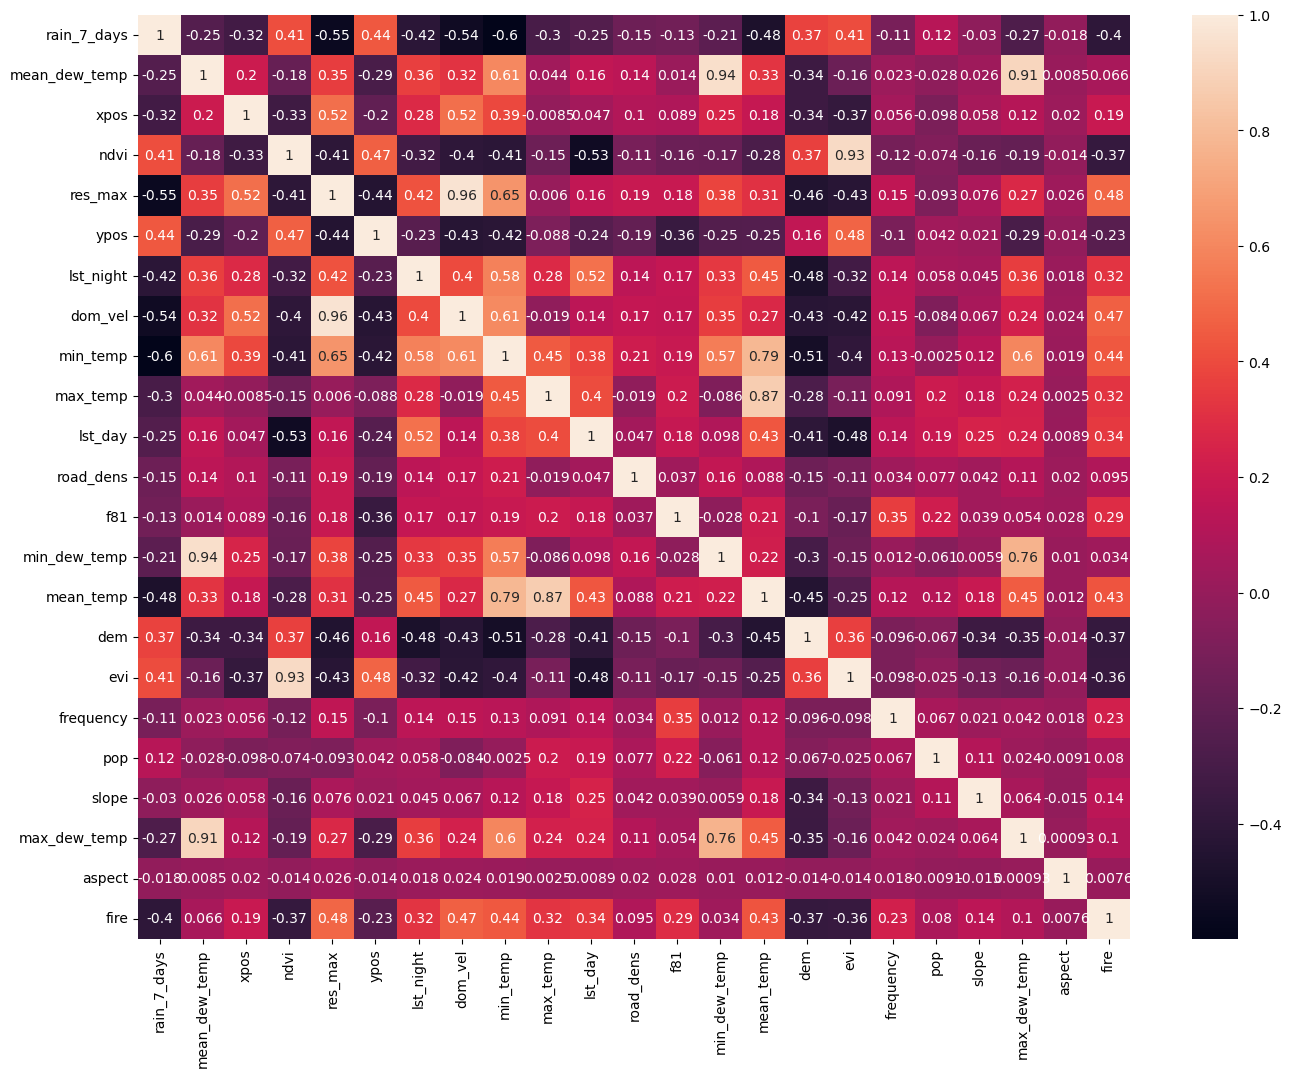

In [35]:
dfcorr=pd.concat([X_pd,y_pd], axis=1)
plot_spearman(dfcorr)

In [64]:
dfall=pd.read_csv('/mnt/nvme2tb/ffp/datasets/fires_new_norm.csv')
cols=dfall.columns
corgr = [c for c in dfall.columns if 'corine_gr' in c]
X_pd2, y_pd2, groups_pd = load_dataset('/mnt/nvme2tb/ffp/datasets/fires_new_norm.csv',
                                       ['bin_dir', 'bin_month', 'bin_week', 'temp', 'lst', 'max', 'rain','pos','dom','vi',
                                       'dem', 'frequency', 'bin_corine_gr33', 'pop','slope', 'aspect'])

Loading full dataset /mnt/nvme2tb/ffp/datasets/fires_new_norm.csv
before nan drop: 26604
after nan drop: 26604
after dup. drop: 26517
renaming "x": "xpos", "y": "ypos"
Ignored columns from csv ['Unnamed: 0', 'dom_dir', 'dir_max', 'fire', 'weekday', 'month', 'x', 'y', 'firedate', 'band']
Dropped columns ['bin_weekday_2', 'rain_7_days', 'mean_dew_temp', 'ndvi', 'bin_dom_dir_7', 'res_max', 'bin_dom_dir_5', 'bin_dir_max_6', 'bin_month_6', 'bin_dir_max_1', 'bin_dom_dir_8', 'bin_dir_max_7', 'bin_month_9', 'max_dew_temp', 'lst_night', 'bin_dir_max_3', 'dom_vel', 'bin_month_5', 'min_temp', 'bin_dom_dir_1', 'xpos', 'max_temp', 'bin_dom_dir_6', 'bin_dir_max_4', 'bin_month_10', 'lst_day', 'bin_dir_max_2', 'bin_weekday_7', 'bin_weekday_1', 'bin_weekday_6', 'bin_weekday_3', 'bin_month_8', 'bin_weekday_4', 'min_dew_temp', 'bin_dom_dir_4', 'bin_dom_dir_2', 'bin_month_3', 'bin_dom_dir_3', 'bin_month_7', 'aspect', 'bin_dir_max_5', 'bin_dir_max_8', 'mean_temp', 'dem', 'evi', 'frequency', 'pop', 'bin_mon

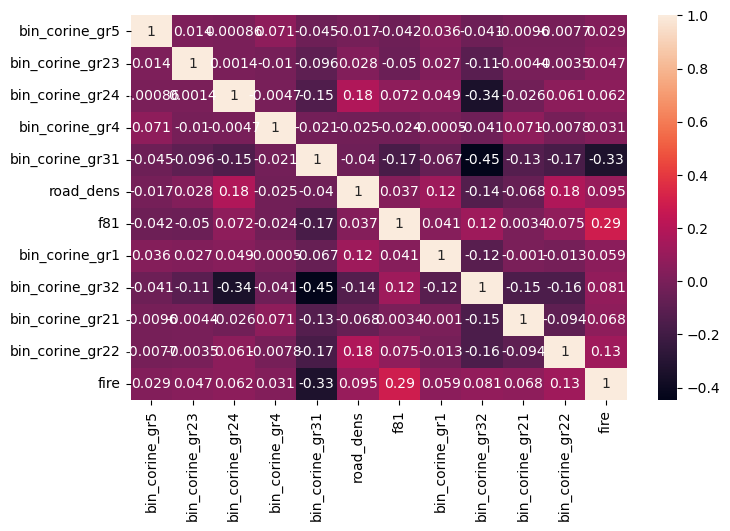

In [70]:
dfcorr=pd.concat([X_pd2,y_pd2], axis=1)
plot_spearman(dfcorr, (8,5))